# GANmapper: Genrating building profile with road network

In [1]:
from PIL import Image, ImageOps
import torchvision.transforms.functional as TF
import random
import os
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim

In [2]:
from ccai9012 import gan_utils

In [3]:
# --------------------------
# Paths
# --------------------------
source_root = "data/Exp4"

# Create directories if not exist
gan_utils.setup_directories(source_root)
train_root = "data/train"
test_root = "data/test"

# --------------------------
# Collect all image pairs
# --------------------------
pairs = gan_utils.collect_image_pairs(source_root)

# Shuffle and split
train_pairs, test_pairs = gan_utils.split_pairs(pairs)

# Copy images and rename
gan_utils.copy_pair(train_pairs, train_root)
gan_utils.copy_pair(test_pairs, test_root)

print(f"Train pairs: {len(train_pairs)}")
print(f"Test pairs: {len(test_pairs)}")

Train pairs: 203
Test pairs: 36


## Data preperation

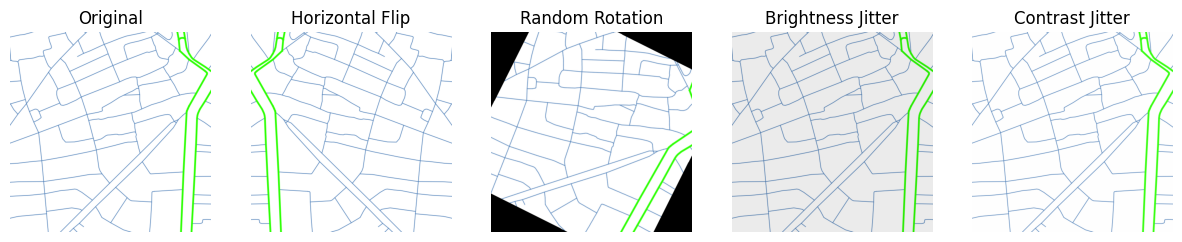

In [4]:
# Load example image
img_A = Image.open("data/train/A/Jakarta_16_52219_33892.png")
img_B = Image.open("data/train/B/Jakarta_16_52219_33892.png")

# Set random seed for reproducibility
random.seed(42)

# Prepare a list of example augmentations
examples = []

# 1. Original (no augmentation)
examples.append(("Original", img_A))

# 2. Horizontal flip only
random.seed(1)
aug_A, _ = gan_utils.augment_pair(img_A, img_B, flip_prob=1.0, rotate_prob=0.0, brightness=0.0, contrast=0.0)
examples.append(("Horizontal Flip", aug_A))

# 3. Random rotation only
random.seed(2)
aug_A, _ = gan_utils.augment_pair(img_A, img_B, flip_prob=0.0, rotate_prob=1.0, max_rotation=30, brightness=0.0, contrast=0.0)
examples.append(("Random Rotation", aug_A))

# 4. Brightness adjustment only
random.seed(3)
aug_A, _ = gan_utils.augment_pair(img_A, img_B, flip_prob=0.0, rotate_prob=0.0, brightness=0.3, contrast=0.0)
examples.append(("Brightness Jitter", aug_A))

# 5. Contrast adjustment only
random.seed(4)
aug_A, _ = gan_utils.augment_pair(img_A, img_B, flip_prob=0.0, rotate_prob=0.0, brightness=0.0, contrast=0.3)
examples.append(("Contrast Jitter", aug_A))

# --------------------------
# Visualization
# --------------------------
plt.figure(figsize=(15,4))
for i, (title, img) in enumerate(examples):
    plt.subplot(1, len(examples), i+1)
    plt.imshow(img)
    plt.title(title)
    plt.axis('off')
plt.show()

In [5]:
# Paths
src_A_dir = "data/train/A"
src_B_dir = "data/train/B"
aug_A_dir = "data/train_aug/A"
aug_B_dir = "data/train_aug/B"

os.makedirs(aug_A_dir, exist_ok=True)
os.makedirs(aug_B_dir, exist_ok=True)

# Number of augmentations per image
num_augment = 5

# Loop over all images
valid_exts = ('.png', '.jpg', '.jpeg', '.bmp', '.tif', '.tiff')
all_images = [f for f in os.listdir(src_A_dir) if f.lower().endswith(valid_exts)]

for fname in tqdm(all_images):
    path_A = os.path.join(src_A_dir, fname)
    path_B = os.path.join(src_B_dir, fname)

    img_A = Image.open(path_A).convert('RGB')
    img_B = Image.open(path_B).convert('RGB')

    # Save original first
    img_A.save(os.path.join(aug_A_dir, fname))
    img_B.save(os.path.join(aug_B_dir, fname))

    # Generate augmentations
    for i in range(num_augment):
        random.seed(i)  # For reproducibility
        aug_A, aug_B = gan_utils.augment_pair(
            img_A, img_B,
            flip_prob=0.5,
            rotate_prob=0.5,
            max_rotation=30,
            brightness=0.2,
            contrast=0.2
        )

        # New filename
        base_name = os.path.splitext(fname)[0]
        new_name = f"{base_name}_aug{i}.png"

        aug_A.save(os.path.join(aug_A_dir, new_name))
        aug_B.save(os.path.join(aug_B_dir, new_name))

100%|████████████████████████████████████████████████████████████████████████████████████████| 203/203 [00:19<00:00, 10.65it/s]


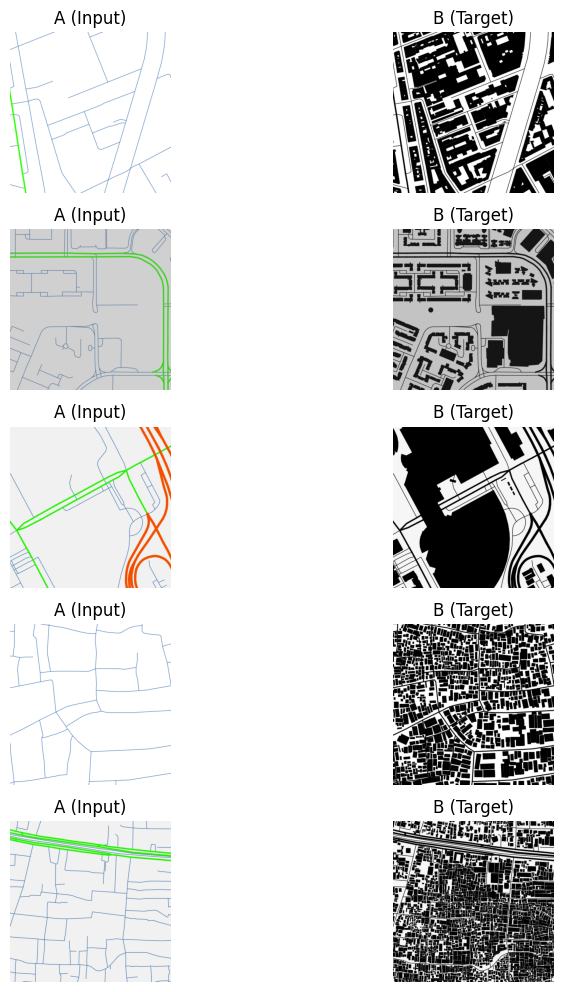

In [6]:
# original image pairs showing

# Train folders
train_A_dir = 'data/train_aug/A'
train_B_dir = 'data/train_aug/B'

# List all images and sort to ensure pairing
A_images = sorted(os.listdir(train_A_dir))
B_images = sorted(os.listdir(train_B_dir))

# Make sure lengths match
assert len(A_images) == len(B_images), "A and B must have the same number of images"

# Randomly sample 5 image indices
sample_indices = random.sample(range(len(A_images)), 5)

plt.figure(figsize=(10, 10))  # enlarge figure
for i, idx in enumerate(sample_indices):
    A_path = os.path.join(train_A_dir, A_images[idx])
    B_path = os.path.join(train_B_dir, B_images[idx])
    
    A_img = Image.open(A_path).convert("RGB")
    
    B_img = Image.open(B_path).convert("RGBA")  # retain alpha
    background = Image.new("RGB", B_img.size, (255, 255, 255))  # white background
    background.paste(B_img, mask=B_img.split()[3])  # masking with alpha
    B_img = background
    
    # Display A
    plt.subplot(5, 2, i*2 + 1)
    plt.imshow(A_img)
    plt.title("A (Input)")
    plt.axis("off")
    
    # Display B
    plt.subplot(5, 2, i*2 + 2)
    plt.imshow(B_img)
    plt.title("B (Target)")
    plt.axis("off")

plt.tight_layout(pad=1.0)
plt.show()

## Define model (CondtionalGAN/Pix2Pix style) and initialize

In [7]:
# Set random seed and device
torch.manual_seed(42)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Training configurations
TRAIN_DIR = 'data/train_aug'  # Directory for training data
TEST_DIR = 'data/test'    # Directory for test data
EPOCHS = 50             # Total training epochs
BATCH_SIZE = 32          # Batch size for training
LR = 0.0002            # Learning rate
BETAS = (0.5,0.999)            # Beta1 for Adam optimizer

In [8]:
# Initialize data loader
train_loader = gan_utils.create_paired_data_loader(TRAIN_DIR, batch_size=BATCH_SIZE)

In [9]:
# Initialize networks
G = gan_utils.UNetGenerator().to(device)
D = gan_utils.PatchDiscriminator().to(device)

criterion_GAN = nn.MSELoss()
criterion_L1 = nn.L1Loss()

optimizer_G = optim.Adam(G.parameters(), lr=LR, betas=BETAS)
optimizer_D = optim.Adam(D.parameters(), lr=LR, betas=BETAS)

## Train model

In [11]:
G_trained, log = gan_utils.train_GAN(G, D, train_loader, num_epochs=EPOCHS, log_interval=10,
                           save_dir='checkpoints', save_interval=10)

/Users/kanxuanhe/Document/250421_AI_course/toolkit/ccai9012/llm_utils.py:559: LangChainDeprecationWarning: Importing HuggingFaceEmbeddings from langchain.embeddings is deprecated. Please replace deprecated imports:

>> from langchain.embeddings import HuggingFaceEmbeddings

with new imports of:

>> from langchain_community.embeddings import HuggingFaceEmbeddings
You can use the langchain cli to **automatically** upgrade many imports. Please see documentation here <https://python.langchain.com/docs/versions/v0_2/>
  from langchain.embeddings import HuggingFaceEmbeddings
/Users/kanxuanhe/Document/250421_AI_course/toolkit/ccai9012/llm_utils.py:559: LangChainDeprecationWarning: Importing HuggingFaceEmbeddings from langchain.embeddings is deprecated. Please replace deprecated imports:

>> from langchain.embeddings import HuggingFaceEmbeddings

with new imports of:

>> from langchain_community.embeddings import HuggingFaceEmbeddings
You can use the langchain cli to **automatically** upgrade 

Epoch [1/50] Step [0/39] Loss D: 0.1861, Loss G: 68.7551
Epoch [1/50] Step [10/39] Loss D: 0.1796, Loss G: 66.6897
Epoch [1/50] Step [20/39] Loss D: 0.1959, Loss G: 64.0030
Epoch [1/50] Step [30/39] Loss D: 0.1811, Loss G: 65.1814


/Users/kanxuanhe/Document/250421_AI_course/toolkit/ccai9012/llm_utils.py:559: LangChainDeprecationWarning: Importing HuggingFaceEmbeddings from langchain.embeddings is deprecated. Please replace deprecated imports:

>> from langchain.embeddings import HuggingFaceEmbeddings

with new imports of:

>> from langchain_community.embeddings import HuggingFaceEmbeddings
You can use the langchain cli to **automatically** upgrade many imports. Please see documentation here <https://python.langchain.com/docs/versions/v0_2/>
  from langchain.embeddings import HuggingFaceEmbeddings
/Users/kanxuanhe/Document/250421_AI_course/toolkit/ccai9012/llm_utils.py:559: LangChainDeprecationWarning: Importing HuggingFaceEmbeddings from langchain.embeddings is deprecated. Please replace deprecated imports:

>> from langchain.embeddings import HuggingFaceEmbeddings

with new imports of:

>> from langchain_community.embeddings import HuggingFaceEmbeddings
You can use the langchain cli to **automatically** upgrade 

Epoch [2/50] Step [0/39] Loss D: 0.1603, Loss G: 67.0928
Epoch [2/50] Step [10/39] Loss D: 0.1756, Loss G: 58.1393
Epoch [2/50] Step [20/39] Loss D: 0.1366, Loss G: 61.6637
Epoch [2/50] Step [30/39] Loss D: 0.1515, Loss G: 61.4681


/Users/kanxuanhe/Document/250421_AI_course/toolkit/ccai9012/llm_utils.py:559: LangChainDeprecationWarning: Importing HuggingFaceEmbeddings from langchain.embeddings is deprecated. Please replace deprecated imports:

>> from langchain.embeddings import HuggingFaceEmbeddings

with new imports of:

>> from langchain_community.embeddings import HuggingFaceEmbeddings
You can use the langchain cli to **automatically** upgrade many imports. Please see documentation here <https://python.langchain.com/docs/versions/v0_2/>
  from langchain.embeddings import HuggingFaceEmbeddings
/Users/kanxuanhe/Document/250421_AI_course/toolkit/ccai9012/llm_utils.py:559: LangChainDeprecationWarning: Importing HuggingFaceEmbeddings from langchain.embeddings is deprecated. Please replace deprecated imports:

>> from langchain.embeddings import HuggingFaceEmbeddings

with new imports of:

>> from langchain_community.embeddings import HuggingFaceEmbeddings
You can use the langchain cli to **automatically** upgrade 

Epoch [3/50] Step [0/39] Loss D: 0.1183, Loss G: 60.8431
Epoch [3/50] Step [10/39] Loss D: 0.1730, Loss G: 59.5346
Epoch [3/50] Step [20/39] Loss D: 0.1302, Loss G: 59.6821
Epoch [3/50] Step [30/39] Loss D: 0.1296, Loss G: 60.4648


/Users/kanxuanhe/Document/250421_AI_course/toolkit/ccai9012/llm_utils.py:559: LangChainDeprecationWarning: Importing HuggingFaceEmbeddings from langchain.embeddings is deprecated. Please replace deprecated imports:

>> from langchain.embeddings import HuggingFaceEmbeddings

with new imports of:

>> from langchain_community.embeddings import HuggingFaceEmbeddings
You can use the langchain cli to **automatically** upgrade many imports. Please see documentation here <https://python.langchain.com/docs/versions/v0_2/>
  from langchain.embeddings import HuggingFaceEmbeddings
/Users/kanxuanhe/Document/250421_AI_course/toolkit/ccai9012/llm_utils.py:559: LangChainDeprecationWarning: Importing HuggingFaceEmbeddings from langchain.embeddings is deprecated. Please replace deprecated imports:

>> from langchain.embeddings import HuggingFaceEmbeddings

with new imports of:

>> from langchain_community.embeddings import HuggingFaceEmbeddings
You can use the langchain cli to **automatically** upgrade 

Epoch [4/50] Step [0/39] Loss D: 0.1799, Loss G: 63.7705
Epoch [4/50] Step [10/39] Loss D: 0.1175, Loss G: 59.3911
Epoch [4/50] Step [20/39] Loss D: 0.2447, Loss G: 57.3807
Epoch [4/50] Step [30/39] Loss D: 0.1436, Loss G: 61.8565


/Users/kanxuanhe/Document/250421_AI_course/toolkit/ccai9012/llm_utils.py:559: LangChainDeprecationWarning: Importing HuggingFaceEmbeddings from langchain.embeddings is deprecated. Please replace deprecated imports:

>> from langchain.embeddings import HuggingFaceEmbeddings

with new imports of:

>> from langchain_community.embeddings import HuggingFaceEmbeddings
You can use the langchain cli to **automatically** upgrade many imports. Please see documentation here <https://python.langchain.com/docs/versions/v0_2/>
  from langchain.embeddings import HuggingFaceEmbeddings
/Users/kanxuanhe/Document/250421_AI_course/toolkit/ccai9012/llm_utils.py:559: LangChainDeprecationWarning: Importing HuggingFaceEmbeddings from langchain.embeddings is deprecated. Please replace deprecated imports:

>> from langchain.embeddings import HuggingFaceEmbeddings

with new imports of:

>> from langchain_community.embeddings import HuggingFaceEmbeddings
You can use the langchain cli to **automatically** upgrade 

Epoch [5/50] Step [0/39] Loss D: 0.3497, Loss G: 58.9675
Epoch [5/50] Step [10/39] Loss D: 0.1441, Loss G: 60.2163
Epoch [5/50] Step [20/39] Loss D: 0.1447, Loss G: 60.0460
Epoch [5/50] Step [30/39] Loss D: 0.1560, Loss G: 58.3435


/Users/kanxuanhe/Document/250421_AI_course/toolkit/ccai9012/llm_utils.py:559: LangChainDeprecationWarning: Importing HuggingFaceEmbeddings from langchain.embeddings is deprecated. Please replace deprecated imports:

>> from langchain.embeddings import HuggingFaceEmbeddings

with new imports of:

>> from langchain_community.embeddings import HuggingFaceEmbeddings
You can use the langchain cli to **automatically** upgrade many imports. Please see documentation here <https://python.langchain.com/docs/versions/v0_2/>
  from langchain.embeddings import HuggingFaceEmbeddings
/Users/kanxuanhe/Document/250421_AI_course/toolkit/ccai9012/llm_utils.py:559: LangChainDeprecationWarning: Importing HuggingFaceEmbeddings from langchain.embeddings is deprecated. Please replace deprecated imports:

>> from langchain.embeddings import HuggingFaceEmbeddings

with new imports of:

>> from langchain_community.embeddings import HuggingFaceEmbeddings
You can use the langchain cli to **automatically** upgrade 

Epoch [6/50] Step [0/39] Loss D: 0.1926, Loss G: 62.3885
Epoch [6/50] Step [10/39] Loss D: 0.0987, Loss G: 61.8850
Epoch [6/50] Step [20/39] Loss D: 0.0908, Loss G: 55.6780
Epoch [6/50] Step [30/39] Loss D: 0.1296, Loss G: 59.7200


/Users/kanxuanhe/Document/250421_AI_course/toolkit/ccai9012/llm_utils.py:559: LangChainDeprecationWarning: Importing HuggingFaceEmbeddings from langchain.embeddings is deprecated. Please replace deprecated imports:

>> from langchain.embeddings import HuggingFaceEmbeddings

with new imports of:

>> from langchain_community.embeddings import HuggingFaceEmbeddings
You can use the langchain cli to **automatically** upgrade many imports. Please see documentation here <https://python.langchain.com/docs/versions/v0_2/>
  from langchain.embeddings import HuggingFaceEmbeddings
/Users/kanxuanhe/Document/250421_AI_course/toolkit/ccai9012/llm_utils.py:559: LangChainDeprecationWarning: Importing HuggingFaceEmbeddings from langchain.embeddings is deprecated. Please replace deprecated imports:

>> from langchain.embeddings import HuggingFaceEmbeddings

with new imports of:

>> from langchain_community.embeddings import HuggingFaceEmbeddings
You can use the langchain cli to **automatically** upgrade 

Epoch [7/50] Step [0/39] Loss D: 0.1594, Loss G: 59.5692
Epoch [7/50] Step [10/39] Loss D: 0.0711, Loss G: 61.7010
Epoch [7/50] Step [20/39] Loss D: 0.0845, Loss G: 59.5036
Epoch [7/50] Step [30/39] Loss D: 0.1098, Loss G: 56.8263


/Users/kanxuanhe/Document/250421_AI_course/toolkit/ccai9012/llm_utils.py:559: LangChainDeprecationWarning: Importing HuggingFaceEmbeddings from langchain.embeddings is deprecated. Please replace deprecated imports:

>> from langchain.embeddings import HuggingFaceEmbeddings

with new imports of:

>> from langchain_community.embeddings import HuggingFaceEmbeddings
You can use the langchain cli to **automatically** upgrade many imports. Please see documentation here <https://python.langchain.com/docs/versions/v0_2/>
  from langchain.embeddings import HuggingFaceEmbeddings
/Users/kanxuanhe/Document/250421_AI_course/toolkit/ccai9012/llm_utils.py:559: LangChainDeprecationWarning: Importing HuggingFaceEmbeddings from langchain.embeddings is deprecated. Please replace deprecated imports:

>> from langchain.embeddings import HuggingFaceEmbeddings

with new imports of:

>> from langchain_community.embeddings import HuggingFaceEmbeddings
You can use the langchain cli to **automatically** upgrade 

Epoch [8/50] Step [0/39] Loss D: 0.1801, Loss G: 59.9848
Epoch [8/50] Step [10/39] Loss D: 0.1426, Loss G: 59.0365
Epoch [8/50] Step [20/39] Loss D: 0.0747, Loss G: 60.3158
Epoch [8/50] Step [30/39] Loss D: 0.0769, Loss G: 58.2199


/Users/kanxuanhe/Document/250421_AI_course/toolkit/ccai9012/llm_utils.py:559: LangChainDeprecationWarning: Importing HuggingFaceEmbeddings from langchain.embeddings is deprecated. Please replace deprecated imports:

>> from langchain.embeddings import HuggingFaceEmbeddings

with new imports of:

>> from langchain_community.embeddings import HuggingFaceEmbeddings
You can use the langchain cli to **automatically** upgrade many imports. Please see documentation here <https://python.langchain.com/docs/versions/v0_2/>
  from langchain.embeddings import HuggingFaceEmbeddings
/Users/kanxuanhe/Document/250421_AI_course/toolkit/ccai9012/llm_utils.py:559: LangChainDeprecationWarning: Importing HuggingFaceEmbeddings from langchain.embeddings is deprecated. Please replace deprecated imports:

>> from langchain.embeddings import HuggingFaceEmbeddings

with new imports of:

>> from langchain_community.embeddings import HuggingFaceEmbeddings
You can use the langchain cli to **automatically** upgrade 

Epoch [9/50] Step [0/39] Loss D: 0.1801, Loss G: 61.2093
Epoch [9/50] Step [10/39] Loss D: 0.0998, Loss G: 59.3656


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x11b71b9c0>
Traceback (most recent call last):
  File "/opt/anaconda3/envs/ccai9012/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
    self._shutdown_workers()
  File "/opt/anaconda3/envs/ccai9012/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1627, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/opt/anaconda3/envs/ccai9012/lib/python3.13/multiprocessing/process.py", line 149, in join
    res = self._popen.wait(timeout)
  File "/opt/anaconda3/envs/ccai9012/lib/python3.13/multiprocessing/popen_fork.py", line 41, in wait
    if not wait([self.sentinel], timeout):
  File "/opt/anaconda3/envs/ccai9012/lib/python3.13/multiprocessing/connection.py", line 1148, in wait
    ready = selector.select(timeout)
  File "/opt/anaconda3/envs/ccai9012/lib/python3.13/selectors.py", line 398, in select
    fd_event_list = self._selector.poll

KeyboardInterrupt: 

## Inference
**Note:** This demo uses a small training set and only a few training epochs, so the generation results are not optimal. The purpose here is solely to illustrate the pipeline. For your own projects, you should choose an appropriate model and fine-tune it according to the size and characteristics of your dataset to achieve better performance. For low-resolution GAN training (e.g., 64×64), dataset of roughly a few thousand to around 10,000 image pairs is typically sufficient to obtain reasonable results.

In [10]:
# Load trained generator
model_path = os.path.join('checkpoints', f'G_epoch_{EPOCHS}.pth')
G = gan_utils.UNetGenerator()
G_trained = gan_utils.load_model(G, model_path=model_path)

In [12]:
test_A_dir = 'data/test/A'
results_dir = 'results/'
os.makedirs(results_dir, exist_ok=True)

fake_B_img = gan_utils.inference_gan(G_trained, test_A_dir, results_dir)

Inference done! Results saved to results/


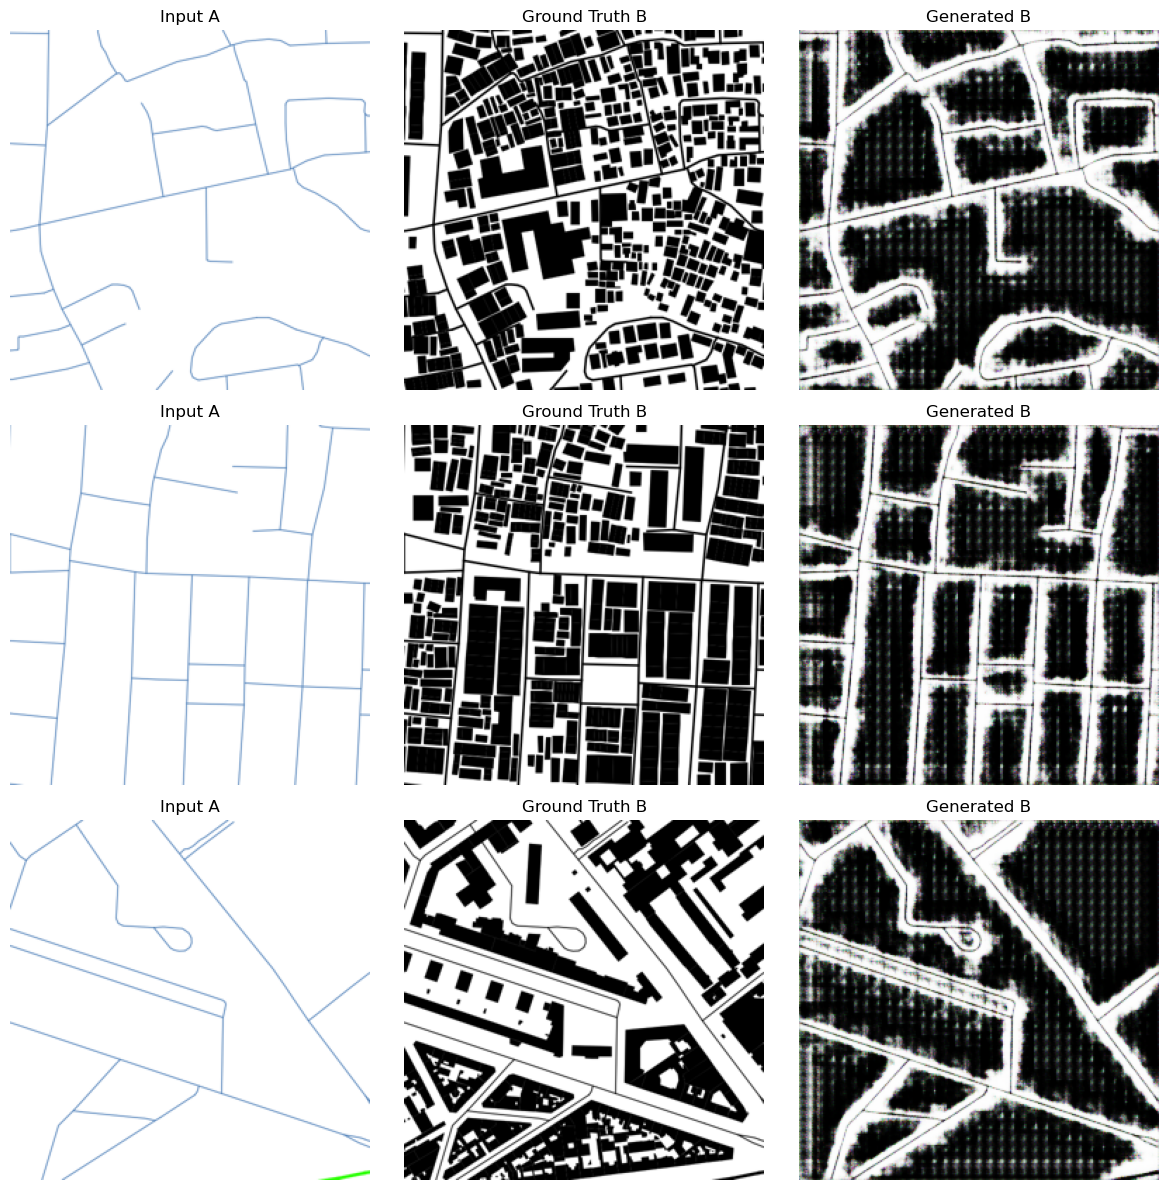

In [13]:
# Directories
test_A_dir = 'data/test/A'
test_B_dir = 'data/test/B'
results_dir = 'results/'

# choose random samples
sample_num = 3
all_test_imgs = sorted(os.listdir(test_A_dir))
sample_imgs = random.sample(all_test_imgs, min(sample_num, len(all_test_imgs)))

fig, axes = plt.subplots(len(sample_imgs), 3, figsize=(12, 4*len(sample_imgs)))

for row, img_name in enumerate(sample_imgs):
    # Paths
    A_path = os.path.join(test_A_dir, img_name)
    B_path = os.path.join(test_B_dir, img_name)
    fake_path = os.path.join(results_dir, img_name)

    # Load images
    A_img = Image.open(A_path).convert("RGB").resize((256,256))
    B_img = Image.open(B_path).convert("RGB").resize((256,256))
    fake_B_img = Image.open(fake_path).convert("RGB").resize((256,256))

    # Plot
    axes[row, 0].imshow(A_img)
    axes[row, 0].set_title("Input A")
    axes[row, 0].axis("off")

    axes[row, 1].imshow(B_img)
    axes[row, 1].set_title("Ground Truth B")
    axes[row, 1].axis("off")

    axes[row, 2].imshow(fake_B_img)
    axes[row, 2].set_title("Generated B")
    axes[row, 2].axis("off")

plt.tight_layout()
plt.show()